# DATA PREPARATION

In this phase we are going to create new variables or transform the existing ones in order to give a better response to our objective.

We are going to give examples of both how to use internal variables and how to enrich with external variables.

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Autocomplete
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

## IMPORT THE DATA

In [3]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df', con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2,district
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,2,180,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,2,364,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,5,222,"Apartamento de tres dormitorios dobles, gran s...",f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,1,115,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,1,349,Nice and cozy roon for one person with a priva...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela


## PREPARATION OF VARIABLES

### KPIs Creation

First we are going to create the analysis variables, that is, those that we had identified as the Kpis that we will use in the levers that influence the business.

We had said that there were 3:

* price per night: we already have this directly in the price variable, but we are going to review it to see that we understand it correctly
* occupation: we have availability_365 but it must be transformed
* price of the property: we will have to create this with external variables so we leave it for later

**We start with the price.**

The documentation does not clarify whether the price is for the entire property, or if a room is rented, it is per room.

It is a key piece of information to be able to make an assessment of the potential income of a property.

We are going to try to understand it by analyzing the average price by type of rental.

It is important to filter by only one district so as not to include the "zone" effect.

So first we choose a district that has a lot of data.

In [4]:
df.district.value_counts()

Centro                   8127
Salamanca                1218
Chamberí                 1089
Arganzuela               1005
Tetuán                    762
Retiro                    618
Carabanchel               581
Chamartín                 538
Ciudad Lineal             532
Moncloa - Aravaca         493
Puente de Vallecas        465
San Blas - Canillejas     463
Latina                    455
Hortaleza                 354
Fuencarral - El Pardo     265
Usera                     233
Barajas                   142
Villaverde                129
Moratalaz                  94
Villa de Vallecas          90
Vicálvaro                  57
Name: district, dtype: int64

In [5]:
df.loc[df.district == 'Centro',:].groupby('room_type').price.mean()

room_type
Entire home/apt    148.859980
Private room        67.131643
Shared room         60.464286
Name: price, dtype: float64

Conclusion:
    
* renting the apartment has an average price of €148
* renting a room has an average price of €60 or €67 depending on whether it is shared or private
* Therefore, to calculate the "income" of a property, we must multiply the price by the number of rooms when it is of the Private room or Shared room types

However, multiplying the price by the total number of rooms can artificially bias upward the income-generating capacity of a property.

Since if it is rented by rooms, it is not likely that it will always be 100%

Therefore we should weight it by the average percentage of rented rooms.

We do not have that data, but suppose we have spoken with the business manager and he has told us that it is 70%.

We can create the total price variable by applying apply on a custom function.

In [6]:
def create_total_price(record):
    if (record.beds > 1) & ((record.room_type == 'Private room') | (record.room_type == 'Shared room')):
        output = record.price * record.beds * 0.7
    else:
        output = record.price
    return(output)

df['total_price'] = df.apply(create_total_price, axis = 1)

We check

In [7]:
df[['room_type','price','beds','total_price']].head(30)

,room_type,price,beds,total_price
0,Private room,60,1.0,60.0
1,Private room,31,1.0,31.0
2,Entire home/apt,50,5.0,50.0
3,Entire home/apt,92,1.0,92.0
4,Private room,26,1.0,26.0
5,Entire home/apt,85,3.0,85.0
6,Entire home/apt,65,2.0,65.0
7,Entire home/apt,54,1.0,54.0
8,Entire home/apt,1400,3.0,1400.0
9,Entire home/apt,81,2.0,81.0


**Now we go with the occupation**

The variable we have that allows us to measure this is availability_365.

This variable tells us the number of days in a year that the property is NOT occupied.

Therefore, we would be interested in transforming it into a more direct measure of occupancy, for example, the % of the year that it IS occupied.

We can do it with a direct transformation.

In [8]:
df['ocupation'] = ((365 - df.availability_365) / 365 * 100).astype('int')
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2,district,total_price,ocupation
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,1,2,180,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín,60.0,50
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,2,364,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina,31.0,0
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,15,5,222,"Apartamento de tres dormitorios dobles, gran s...",f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela,50.0,39
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,1,115,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro,92.0,68
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,2,1,349,Nice and cozy roon for one person with a priva...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela,26.0,4


### Transformation of analysis variables

Some of the seed questions are aimed at checking how the price or occupancy behaves according to other variables such as the number of rooms, the average rating, etc.

Normally we can do these analyzes better if we discretize the analysis variable.

In our case, the candidates for this analysis are: accommodates, bedrooms, beds and number_of_reviews.

In bedrooms, a more personalized discretization makes sense. In the others we can make it automatic.

**Discretize bedrooms**

We begin by evaluating the distribution of the data.

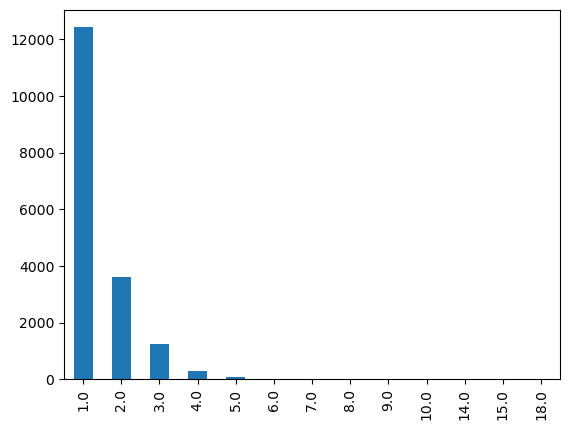

In [9]:
df.bedrooms.value_counts().plot.bar();

We are going to discretize for 1,2,3 and more than 3.

We can use np.select

In [10]:
conditions = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]

results = ['01_One','02_Two','03_Three','04_Four or more']

df['bedrooms_disc'] = np.select(conditions, results, default = -999)

We check

In [11]:
df.bedrooms_disc.value_counts()

01_One             12422
02_Two              3617
03_Three            1228
04_Four or more      443
Name: bedrooms_disc, dtype: int64

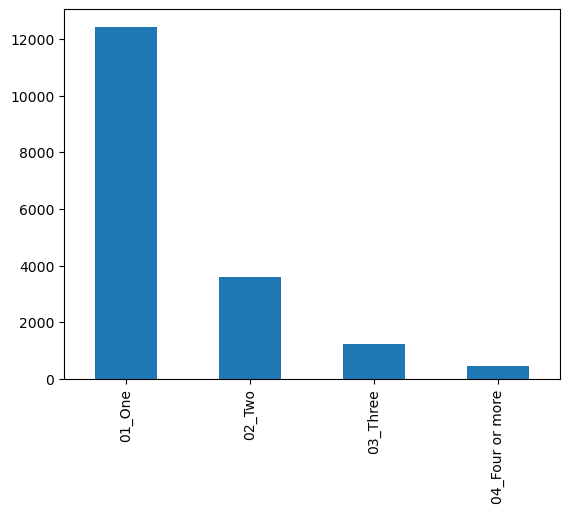

In [12]:
df.bedrooms_disc.value_counts().plot.bar();

**Discretize accommodates, beds and number_of_reviews**

We are going to use qcut to discriminate with percentiles 0.5, 0.8, 1

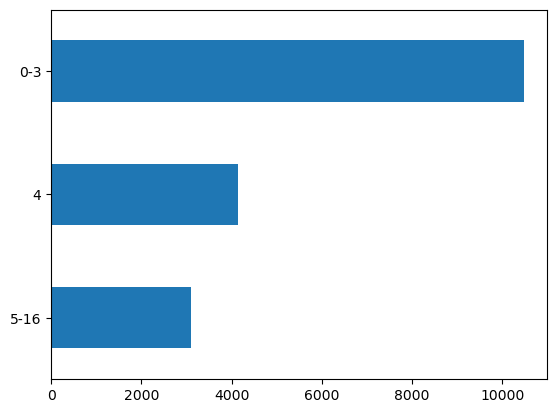

In [13]:
df['accommodates_disc'] = pd.qcut(df.accommodates,[0, 0.5, 0.8, 1],
                                 labels = ['0-3','4','5-16'])

df['accommodates_disc'].value_counts().sort_index(ascending = False).plot.barh();

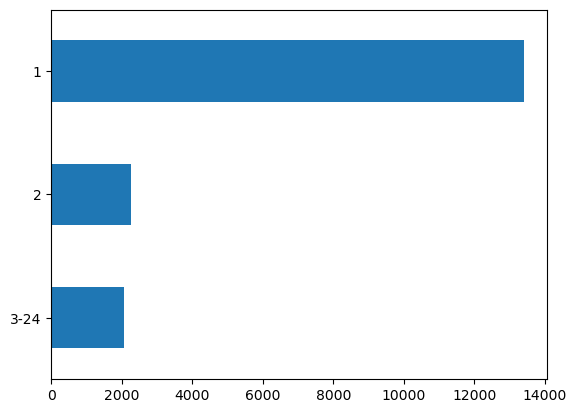

In [14]:
df['beds_disc'] = pd.qcut(df.beds,[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh();

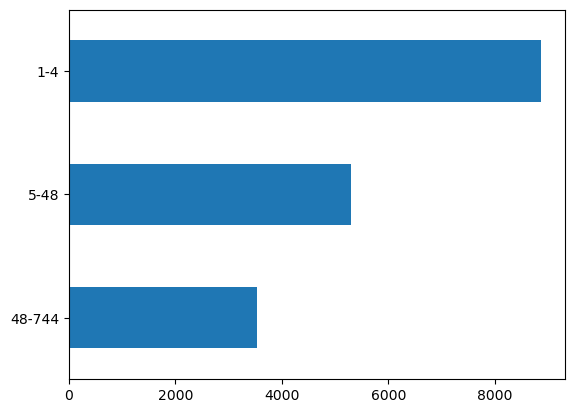

In [15]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','48-744'])

df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh();

### Creating variables with external data

In this particular case, many things could be done with external data.

The first thing, which we have already partially incorporated, is the property price lever.

We said that we could estimate it by multiplying the square meters of the property by the price per m2.

We have already obtained the price_m2, but we do not have the size of the property in the data.

What we can do is establish criteria based on the number of rooms.

It's not perfect, but it will serve as an approximation.

**Estimate of the square meters of the property**

Let's use the following algorithm:

* a room: m2 = 50
* two rooms: m2 = 70
* three rooms: m2 = 90
* four rooms: m2 = 120
* five or more rooms: m2 = 150

In [16]:
conditions = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]

results = [50,70,90,120,150]

df['m2'] = np.select(conditions, results, default = -999)

We check

In [17]:
df['m2'].value_counts()

50     12422
70      3617
90      1228
120      296
150      147
Name: m2, dtype: int64

Now we can estimate the purchase price of the property.

We remember that we took 30% from the price we got for bargaining power.

In [18]:
df['purchase_price'] = df.m2 * df.price_m2 * 0.7

We check

In [19]:
df[['bedrooms','m2','district','price_m2','purchase_price']].head(20)

,bedrooms,m2,district,price_m2,purchase_price
0,1.0,50,Chamartín,5098,178430.0
1,1.0,50,Latina,2267,79345.0
2,3.0,90,Arganzuela,4085,257355.0
3,1.0,50,Centro,4827,168945.0
4,1.0,50,Arganzuela,4085,142975.0
5,3.0,90,Arganzuela,4085,257355.0
6,1.0,50,Centro,4827,168945.0
7,1.0,50,Centro,4827,168945.0
8,2.0,70,Centro,4827,236523.0
9,1.0,50,Centro,4827,168945.0


Now we are going to give an example of what other types of variables we can build.

In this case we could do a lot with the x,y coordinates.

Since in tourism the location is very important.

For example, we could calculate the distances to different points of interest such as monuments, entertainment venues, sports venues, etc.

Simply as an example we are going to calculate the distance from each property to Puerta del Sol.

To do this, we search on Google for its longitude and latitude:

https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitude: 40.4167278
Longitude: -3.7033387

**Calculation of the distance of each property to Puerta del Sol**

Given the curvature of the earth, the distance between two points based on their latitude and longitude is calculated using a formula called the Haversine distance.

A search on Google gives us a function already built to calculate it that we can adapt: 

https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [20]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #In km, if you use miles you have to change it to 3959.87433
      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

Create the variable

In [22]:
#The coordinates of Puerta del Sol will be lat1 and lon1
lat1 = 40.4167278
lon1 = -3.7033387

df['poi_sol'] = df.apply(lambda register: haversine(lat1,lon1,register.latitude,register.longitude),axis = 1)

We check by reviewing the average distance by districts.

In [23]:
df.groupby('district').poi_sol.mean().sort_values()

district
Centro                    0.730611
Arganzuela                1.939114
Chamberí                  2.133167
Retiro                    2.450593
Salamanca                 2.715975
Moncloa - Aravaca         3.294526
Usera                     3.928874
Latina                    3.942634
Carabanchel               3.970238
Chamartín                 4.432842
Puente de Vallecas        4.481127
Tetuán                    4.624605
Moratalaz                 5.073901
Ciudad Lineal             5.231293
Villaverde                7.664192
Fuencarral - El Pardo     8.062301
Hortaleza                 8.074184
San Blas - Canillejas     8.199011
Vicálvaro                 8.599559
Villa de Vallecas         9.176618
Barajas                  11.439064
Name: poi_sol, dtype: float64

## SAVE THE DATAMART

Let's save this version as df_prepared

In [24]:
df.to_sql('df_prepared', con = con, if_exists = 'replace')

17710